# Ensemble learning

Key take-aways
- Bagging is good at reducing the variance of a model, but not at reducing the bias. Therefore use very flexible models as base models (e.g. decision trees).
- Boosting on the other hand, can also reduce the bias of a model. 

 ## PART 1: More classifiers imporve the error

To calculate the error of an ensemble of $n$ independent classifiers that each make errors of $\epsilon$, think of it as a Bernoulli process.
Then each classifier predicts heads with probability $1-\epsilon$. The combined error rate is then the probability that the amount of heads $k$ is smaller than $n/2$:
$$ p(k<\frac{n}{2}) = \sum_{i=1}^{n/2}(1-\epsilon)^k \epsilon^{n-k}$$ 

Let's make a plot:

Text(0, 0.5, 'Error rate')

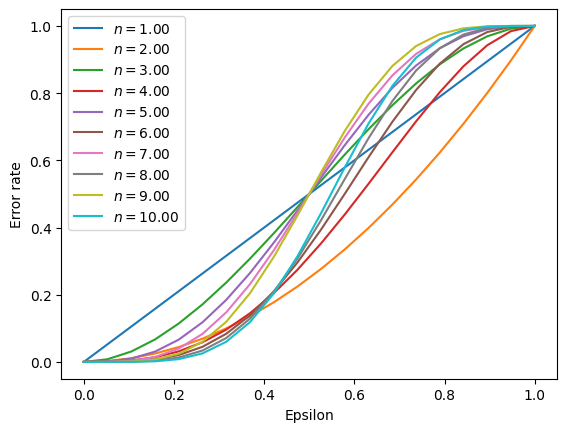

In [29]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt 
num_classifiers = list(range(1,11))
error_rates = list()
epsilons = np.linspace(0, 1, 20)
fig, ax = plt.subplots()
for n in num_classifiers:
    errors = [scipy.stats.binom.cdf(np.floor(n/2), n, 1.0-eps) if n%2 == 1 else scipy.stats.binom.cdf(np.floor(n/2)-1, n, 1.0-eps) for eps in epsilons]
    error_rates.append(errors)
    ax.plot(epsilons, errors, label=f"$n = {n:.2f}$")
plt.legend(loc='upper left')
plt.xlabel("Epsilon")
plt.ylabel("Error rate")

## PART 2: Implementation of a simple majority rule algorithm

In [45]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone 
from sklearn.pipeline import _name_estimators
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {
            key: value for key,value in _name_estimators(classifiers)
        }
        self.vote = vote 
        self.weights = weights
    
    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"Vote must be 'probability' or 'classlabel'; got (vote={self.vote})")
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of weights and numer of classifiers must be equal')
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self 
    
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value 
            return out 

### Prepare dataset

In [35]:
import pandas as pd 
from sklearn import datasets 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1, test_size=0.5)

### Train individual classifiers

In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf1 = LogisticRegression(C=0.001,
                          solver='lbfgs',
                          random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')  # this is the normal p-norm
pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f} [{label}])')


10-fold cross validation

ROC AUC: 0.92 (+/- 0.15 [Logistic regression])
ROC AUC: 0.87 (+/- 0.18 [Decision tree])
ROC AUC: 0.85 (+/- 0.13 [KNN])


### Train majority vote classifier

In [47]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f} [{label}])')

ROC AUC: 0.92 (+/- 0.15 [Logistic regression])
ROC AUC: 0.87 (+/- 0.18 [Decision tree])
ROC AUC: 0.85 (+/- 0.13 [KNN])
ROC AUC: 0.98 (+/- 0.05 [Majority voting])


### ROC curves

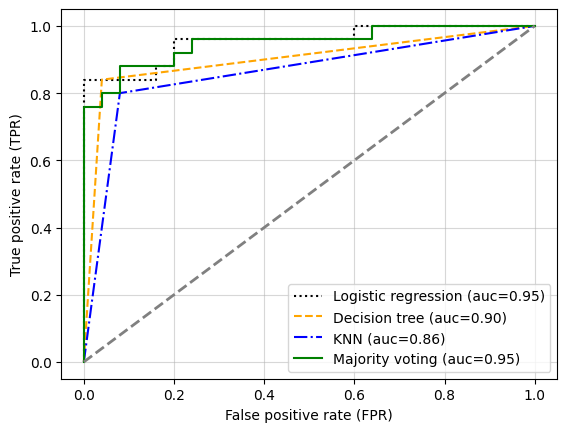

In [48]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]  #select p(y=1|x)
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label=f'{label} (auc={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=2)
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

### Decision boundary

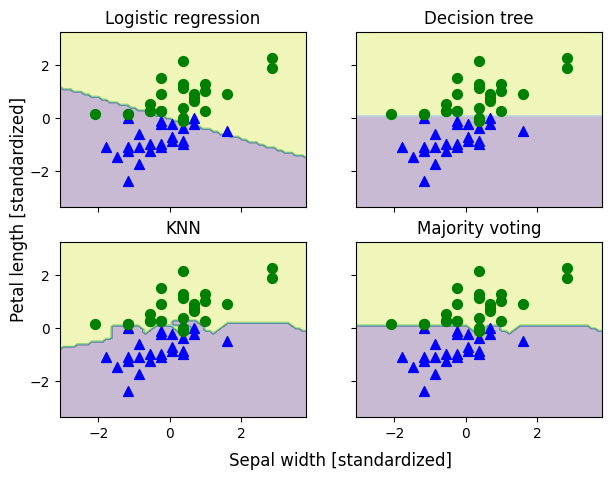

In [49]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product 
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max,0.1))
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])  # concat along second dimension
    z = z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                  X_train_std[y_train==0, 1],
                                  c='blue',
                                  marker='^',
                                  s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                  X_train_std[y_train==1, 1],
                                  c='green',
                                  marker='o',
                                  s=50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -5., s='Sepal width [standardized]', ha="center", va='center', fontsize=12)
plt.text(-12.5, 4.5, s='Petal length [standardized]', ha="center", va='center', fontsize=12, rotation=90)
plt.show()



In [50]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

## PART 3: Bagging

In [31]:
from ucimlrepo import fetch_ucirepo 
wine = fetch_ucirepo(id=109) 
wine_df = pd.concat((wine.data.targets.astype("category"), wine.data.features), axis=1)
wine_df.head()

,class,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [58]:
y = wine_df['class'].values 
X = wine_df[['Alcohol', '0D280_0D315_of_diluted_wines']].values 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=None)
bag = BaggingClassifier(base_estimator=tree, 
                        n_estimators=1000, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1,
                        random_state=1)

In [57]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracy ', f'{tree_train: .3f}/{tree_test:.3f}')

Decision tree train/test accuracy   1.000/0.861


In [59]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracy ', f'{bag_train: .3f}/{bag_test:.3f}')

/home/tom/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Decision tree train/test accuracy   1.000/0.861


## PART 4: BOOSTING